# TOC


* [packages and functions](#0-bullet)
* [Data load](#first-bullet)
* [Plot SLR](#second-bullet)
* [Ice mask change](#3-bullet)
* [thickness change](#4-bullet)
* [velocity change](#5-bullet)
* [surface changes](#6-bullet)



## packages and functions <a class="anchor" id="0-bullet"></a>

In [ ]:


import numpy as np
import dimarray as da
import glob
from matplotlib import pylab as plt
import numpy as np
import dimarray as da
from matplotlib import pylab as plt
from matplotlib import ticker, cm, colors
import cmocean
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
import os
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D
from scipy import stats
import matplotlib.colors
import pandas as pd
import cmocean
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
p_climato= '/home/beckmann/mnt/climato/mapi/output/PISM_intern/output_PISM/'

In [27]:
# Functions
def get_min_max(m):
    mi = np.min(m)
    ma = np.max(m)
    return(np.max([-1*mi,ma]))
def make_ice_only_mask(mask_oo):
    numbers = [1,4]
    for n in numbers:

        m = mask_oo == n
        mask_oo[m] = 0
    numbers = [2,3]
    for n in numbers:

        m = mask_oo== n
        mask_oo[m] = 1
    return(mask_oo)

def make_ice_only_grounded_mask(mask_oo):
    numbers = [1,4,3]
    for n in numbers:

        m = mask_oo == n
        mask_oo[m] = 0
    numbers = [2]
    for n in numbers:

        m = mask_oo== n
        mask_oo[m] = 1
    return(mask_oo)
def create_slr_pot_timeline(lst):
    slr_pot = np.zeros(len(lst))
    for i,name in enumerate(lst):
        d = da.read_nc(name,'sea_level_rise_potential' )
        slr_pot[i]=d.values[0]
    return(slr_pot)
def get_ystart_yend(lst):
    y_0 =lst[0].split('-')[-1].split('.')[0]
    y_e =lst[-1].split('-')[-1].split('.')[0]
    return(eval(y_0),eval(y_e))
def get_path(lst):
    fle=lst[0].split('/')[-1]
    path = lst[0].split(fle)[0]
    return(path)
def creat_slr_pot_nc(lst):
    y0,ye = get_ystart_yend(lst)
    name = 'slt_pot_timeline_'+str(y0)+'-'+str(ye)+'.nc'
    years = np.arange(y0,ye+1)
    path = get_path(lst)
    slr_pot =create_slr_pot_timeline(lst)
    slr=da.DimArray(slr_pot.tolist(),axes = [years],dims = ['years'])
    year=da.DimArray(years.tolist(),axes = [years],dims = ['years'])
    dataset =da.Dataset({'slr_pot':slr})

    dataset.write_nc(path +name)
    
def load_slr_pot_nc(lst):
    y0,ye = get_ystart_yend(lst)
    name = 'slt_pot_timeline_'+str(y0)+'-'+str(ye)+'.nc'
    path = get_path(lst)
    d =da.read_nc(path + name)
    return(d['slr_pot'].values,d.years)


### plot functions

def set_size_gr(width, fraction=1):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float
            Document textwidth or columnwidth in pts
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy

    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    # Width of figure (in pts)
    fig_width_pt = width * fraction

    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio

    fig_dim = (fig_width_in, fig_height_in)

    return fig_dim


# Not super useful. However, Joe Kington created this handy class:

# set the colormap and centre the colorbar
class MidpointNormalize(colors.Normalize):
	"""
	Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

	e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
	"""
	def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
		self.midpoint = midpoint
		colors.Normalize.__init__(self, vmin, vmax, clip)

	def __call__(self, value, clip=None):
		# I'm ignoring masked values and all kinds of edge cases to make a
		# simple example...
		x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
		return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

In [4]:
## plotting style

x_len = 8.27/2
y_len = 11.69/2
width = 345
import seaborn as sns

sns.set_context('paper')
sns.set_style("whitegrid", {'axes.grid' : False,'font.family':'serif', 'font.serif':'Times New Roman'})

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": False,
#     "font.family": "Times New Roman",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    'legend.handlelength': 1
}

plt.rcParams.update(tex_fonts)

## TOC

## create/load data <a class="anchor" id="first-bullet"></a>

### marfix 1-way coupling
Inclused surfce elevation feedback

In [87]:
lst = glob.glob(p_climato+'marfix/ts*.nc')
lst.sort()


In [88]:
CREATE = False
if CREATE:
    creat_slr_pot_nc(lst)
else:
    slr_pot_sef,years = load_slr_pot_nc(lst)

### coupling 2way
includes surface elevation and atmospheric feedback

In [89]:
lst = glob.glob(p_climato+'coupling-1yr/ts*.nc')
lst.sort()
lst =lst[5:]

In [18]:
CREATE = False
if CREATE:
    creat_slr_pot_nc(lst)
else:
    slr_pot_sef_af,years_cp = load_slr_pot_nc(lst)

### standalone
without surface elevation or atmospheric feedback

In [19]:
lst = glob.glob(p_climato+'pism-mar-fix/ts*.nc')
lst.sort()


In [20]:
CREATE = False
if CREATE:
    creat_slr_pot_nc(lst)
else:
    slr_pot_fix,years_mf2 = load_slr_pot_nc(lst)

### Plots SLR <a class="anchor" id="second-bullet"></a>

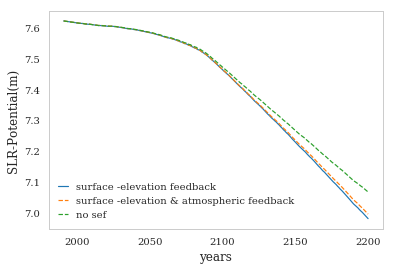

In [37]:
f,ax = plt.subplots(1,1)

ax.plot(years,slr_pot_sef, label ='surface -elevation feedback')
ax.plot(years_cp,slr_pot_sef_af,linestyle= '--',label ='surface -elevation & atmospheric feedback') 
ax.plot(years_mf2,slr_pot_fix,linestyle= '--',label ='no sef') 
ax.set_ylabel('SLR-Potential(m)')
ax.set_xlabel('years')
ax.legend(frameon = False)
plt.show()

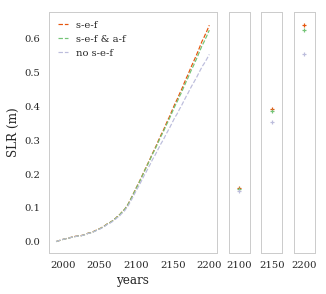

In [80]:
colors = sns.color_palette("tab20c_r",3)
# colors[1] = sns.color_palette("colorblind",4)[2]
# colors[2]= sns.color_palette("colorblind",4)[1]
custom_lines_all = [
    Line2D([0], [0], color=colors[0], linestyle = '--'),
    Line2D([0], [0], color=colors[1], linestyle = '--'),
    Line2D([0], [0], color=colors[2], linestyle = '--'),

]
ww,hh=set_size_gr(width, fraction=1)
# f, ax = plt.subplots(1,1, figsize = (set_size_gr(width, fraction=1)),dpi=150)
f, (ax) = plt.subplots(1, 4, \
                           gridspec_kw={'width_ratios': [4, 0.5,.5,0.5]},\
                           figsize = (ww,hh*1.5),sharey=True)
i=0

ax[i].plot(years,-1*slr_pot_sef+slr_pot_sef[0],color = colors[2],linestyle= '--', label ='s-e-f ')
ax[i].plot(years_cp,-1*slr_pot_sef_af+slr_pot_sef_af[0],color = colors[1],linestyle= '--',label ='s-e-f & a-f')
ax[i].plot(years_mf2,-1*slr_pot_fix +slr_pot_fix[0],color = colors[0],linestyle= '--',label ='no s-e-f') 

ax[i].set_ylabel('SLR (m)')
ax[i].set_xlabel('years')
# ax[i].set_xlim([2050,2100])
# ax[i].set_ylim([0,0.2])
ax[i].legend(frameon = False)
j_s =[109,159,-1]

i_s = [1,2,3]
x_year =[2100,2150,2200]
for p,i in enumerate(i_s):
    j =j_s[p]
    ax[i].scatter(years[j],-1*slr_pot_sef[j]+slr_pot_sef[0],color = colors[2],marker='+')
    ax[i].scatter(years[j],-1*slr_pot_sef_af[j]+slr_pot_sef_af[0],color = colors[1],marker='+') 
    ax[i].scatter(years[j],-1*slr_pot_fix[j] +slr_pot_fix[0],color = colors[0],marker ='+') 
    ax[i].set_xticks([years[j]])


plt.show()

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


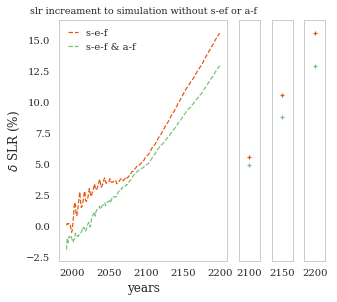

In [82]:
colors = sns.color_palette("tab20c_r",3)
# colors[1] = sns.color_palette("colorblind",4)[2]
# colors[2]= sns.color_palette("colorblind",4)[1]
custom_lines_all = [
    Line2D([0], [0], color=colors[0], linestyle = '--'),
    Line2D([0], [0], color=colors[1], linestyle = '--'),
    Line2D([0], [0], color=colors[2], linestyle = '--'),

]
ww,hh=set_size_gr(width, fraction=1)
# f, ax = plt.subplots(1,1, figsize = (set_size_gr(width, fraction=1)),dpi=150)
f, (ax) = plt.subplots(1, 4, \
                           gridspec_kw={'width_ratios': [4, 0.5,.5,0.5]},\
                           figsize = (ww,hh*1.5),sharey=True)
i=0

slr_sef=-1*slr_pot_sef+slr_pot_sef[0]
slr_sef_af=-1*slr_pot_sef_af+slr_pot_sef_af[0]
slr = -1*slr_pot_fix +slr_pot_fix[0]
ax[i].plot(years,slr_sef/slr*100-100,color = colors[2],linestyle= '--', label ='s-e-f ')
ax[i].plot(years_cp,slr_sef_af/slr*100-100,color = colors[1],linestyle= '--',label ='s-e-f & a-f')

ax[i].set_ylabel('$\delta$ SLR (%)')
ax[i].set_xlabel('years')
# ax[i].set_xlim([2050,2100])
# ax[i].set_ylim([0,0.2])
ax[i].legend(frameon = False)
j_s =[109,159,-1]

i_s = [1,2,3]
x_year =[2100,2150,2200]
for p,i in enumerate(i_s):
    j =j_s[p]

    ax[i].scatter(years[j],slr_sef[j]/slr[j]*100-100,color = colors[2],marker='+')
    ax[i].scatter(years[j],slr_sef_af[j]/slr[j]*100-100,color = colors[1],marker='+') 
    ax[i].set_xticks([years[j]])
    

ax[0].set_title('realtiva SLR to simulation without s-ef or a-f')
plt.show()

Additional SLR compared to the run witout any surface feedback increases with time. After 2100 difference drift further appart. Now lets us compare percentual change between the 2 feedbacks

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


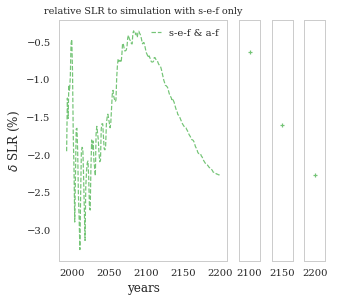

In [84]:
colors = sns.color_palette("tab20c_r",3)
# colors[1] = sns.color_palette("colorblind",4)[2]
# colors[2]= sns.color_palette("colorblind",4)[1]
custom_lines_all = [
    Line2D([0], [0], color=colors[0], linestyle = '--'),
    Line2D([0], [0], color=colors[1], linestyle = '--'),
    Line2D([0], [0], color=colors[2], linestyle = '--'),

]
ww,hh=set_size_gr(width, fraction=1)
# f, ax = plt.subplots(1,1, figsize = (set_size_gr(width, fraction=1)),dpi=150)
f, (ax) = plt.subplots(1, 4, \
                           gridspec_kw={'width_ratios': [4, 0.5,.5,0.5]},\
                           figsize = (ww,hh*1.5),sharey=True)
i=0

slr_sef=-1*slr_pot_sef+slr_pot_sef[0]
slr_sef_af=-1*slr_pot_sef_af+slr_pot_sef_af[0]
slr = slr_sef
# ax[i].plot(years,slr_sef/slr*100-100,color = colors[2],linestyle= '--', label ='s-e-f ')
ax[i].plot(years_cp,slr_sef_af/slr*100-100,color = colors[1],linestyle= '--',label ='s-e-f & a-f')

ax[i].set_ylabel('$\delta$ SLR (%)')
ax[i].set_xlabel('years')
# ax[i].set_xlim([2050,2100])
# ax[i].set_ylim([0,0.2])
ax[i].legend(frameon = False)
j_s =[109,159,-1]

i_s = [1,2,3]
x_year =[2100,2150,2200]
for p,i in enumerate(i_s):
    j =j_s[p]

#     ax[i].scatter(years[j],slr_sef[j]/slr[j]*100-100,color = colors[2],marker='+')
    ax[i].scatter(years[j],slr_sef_af[j]/slr[j]*100-100,color = colors[1],marker='+') 
    ax[i].set_xticks([years[j]])
    

ax[0].set_title('relative SLR to simulation with s-e-f only')
plt.show()

## ice mask <a class="anchor" id="third-bullet"></a>

In [106]:
d_thk0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', 'thk')
m0 =  da.read_nc(p_climato + 'gris_4500m-1990.nc', 'mask')
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'thk')
me_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'mask')

d_thke_standalone = da.read_nc(p_climato + 'marfix/'+'gris_4500m-2200.nc', 'thk')
me_standalone = da.read_nc(p_climato + 'marfix/'+'gris_4500m-2200.nc', 'mask')
## 1990
m_i =m0.values[0].astype('float')
m_orig = make_ice_only_mask(m_i)
# thk_0 = d_thk0.values[0]
mm= m_orig ==0
m_orig_nan = m_orig.copy()
m_orig_nan[mm]=np.nan
m_cp_i= me_coupling.values[0].astype('float')
m_cp= make_ice_only_mask(m_cp_i)
mm = m_cp ==0
m_cp_nan = m_cp.copy()
m_cp_nan[mm]= np.nan
m_sa_i= me_standalone.values[0].astype('float')
m_sa= make_ice_only_mask(m_sa_i)
m_sa_nan = m_sa.copy()
mm = m_sa ==0
m_sa_nan[mm]= np.nan

Text(0.5, 1.0, '2200 s-e-f only')

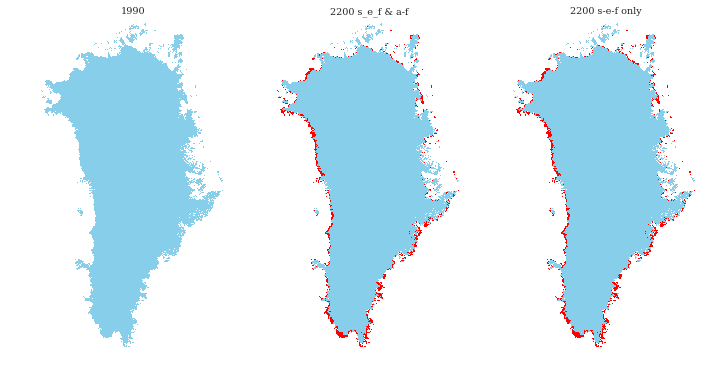

In [107]:
f, ax = plt.subplots(1,3,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(m_orig_nan,origin = 'lower',norm =norm,cmap =cmap)

ax[1].imshow(m_orig_nan,origin = 'lower',norm =norm,cmap =cmap_red)
ax[2].imshow(m_orig_nan,origin = 'lower',norm =norm,cmap =cmap_red)


ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
ax[2].imshow(m_sa_nan,origin = 'lower',norm =norm,cmap =cmap)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[2].set_axis_off()

ax[0].set_title('1990')
ax[1].set_title('2200 s_e_f & a-f')
ax[2].set_title('2200 s-e-f only')

# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)

In [108]:
d_thk0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', 'thk')
m0 =  da.read_nc(p_climato + 'gris_4500m-1990.nc', 'mask')
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'thk')
me_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'mask')

d_thke_standalone1 = da.read_nc(p_climato + 'pism-mar-fix/'+'gris_4500m-2200.nc', 'thk')
me_standalone1 = da.read_nc(p_climato + 'pism-mar-fix/'+'gris_4500m-2200.nc', 'mask')
## 1990
m_i =m0.values[0].astype('float')
m_orig = make_ice_only_mask(m_i)
# thk_0 = d_thk0.values[0]
mm= m_orig ==0
m_orig_nan = m_orig.copy()
m_orig_nan[mm]=np.nan
m_cp_i= me_coupling.values[0].astype('float')
m_cp= make_ice_only_mask(m_cp_i)
mm = m_cp ==0
m_cp_nan = m_cp.copy()
m_cp_nan[mm]= np.nan
m_sa_i1= me_standalone1.values[0].astype('float')
m_sa1= make_ice_only_mask(m_sa_i1)
m_sa_nan1 = m_sa1.copy()
mm1 = m_sa1 ==0
m_sa_nan1[mm1]= np.nan

Text(0.5, 1.0, '2200 without s-e-f or a-f')

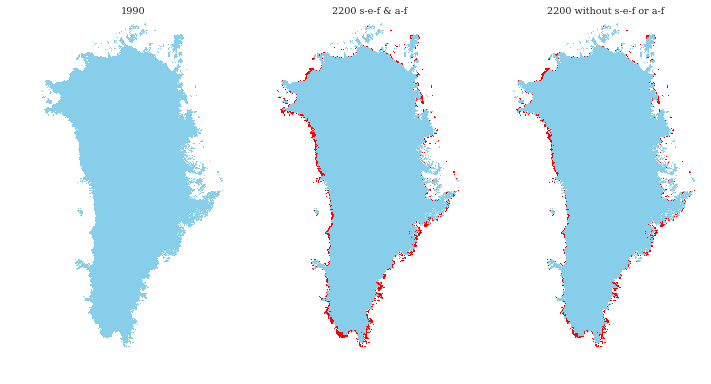

In [109]:
f, ax = plt.subplots(1,3,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(m_orig_nan,origin = 'lower',norm =norm,cmap =cmap)

ax[1].imshow(m_orig_nan,origin = 'lower',norm =norm,cmap =cmap_red)
ax[2].imshow(m_orig_nan,origin = 'lower',norm =norm,cmap =cmap_red)


ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
ax[2].imshow(m_sa_nan1,origin = 'lower',norm =norm,cmap =cmap)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[2].set_axis_off()

ax[0].set_title('1990')
ax[1].set_title('2200 s-e-f & a-f')
ax[2].set_title('2200 without s-e-f or a-f')

# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)

In [110]:
m_diff_i = m_cp -m_sa1
np.unique(m_diff_i)
cmap = colors.ListedColormap(['blue','white','red'])

# cmap_red = colors.ListedColormap(['red'])
bounds=[-1.5,-0.5,0.5,1.5]
bounds_ticks=[-1.,1]
norm = colors.BoundaryNorm(bounds, cmap.N)

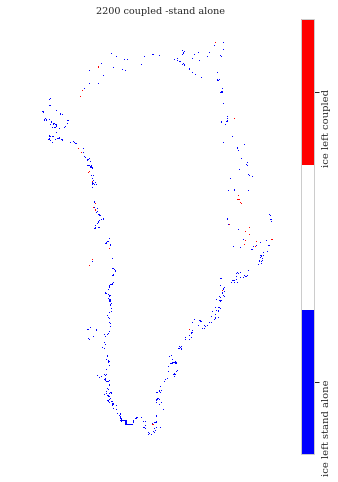

In [111]:
f, ax = plt.subplots(1,1,sharey = True, figsize = (6,8) )
divider = make_axes_locatable(ax)
cax = divider.new_horizontal(size="5%", pad=0.2)
f.add_axes(cax)
im2 = ax.imshow(m_diff_i,origin = 'lower',norm =norm,cmap =cmap)
ax.set_title('2200 coupled -stand alone')
cbar2 =f.colorbar(im2, cax=cax,boundaries=bounds, ticks=bounds_ticks)
# cbar = fig.colorbar(cax, ticks=[-1, 0, 1], orientation='horizontal')
cbar2.ax.set_yticklabels(['ice left stand alone', 'ice left coupled'],rotation = 90)  # horizontal colorbar
ax.set_axis_off()
# ax[1].set_axis_off()

blue shows where  in the pism-mar-fixed scenario is still there, but would be gone in the coupled version

### thickness change <a class="anchor" id="4-bullet"></a>

In [129]:
thk_0  = d_thk0.values[0]
thk_sef = d_thke_standalone.values[0]
thk_e = d_thke_standalone1.values[0]
thk_cp=d_thke_coupling.values[0]

thk_diff = thk_e.copy()-thk_0.copy()
m_ocean = m_i ==0
# thk_diff[m_ocean]= np.nan

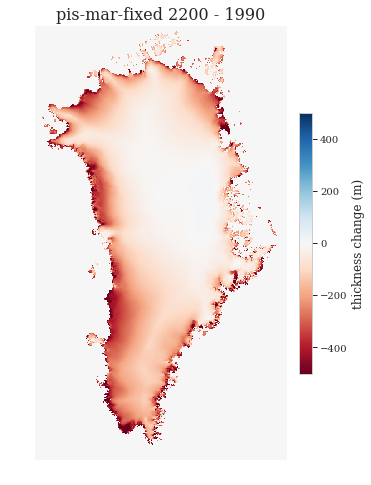

In [130]:
f, ax = plt.subplots(1,1,sharey = True, figsize = (6,8) )
v_max = get_min_max(thk_diff)
v_max = 500
# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu",vmin =-1*v_max,vmax=v_max)
axins1 = inset_axes(ax,
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax.transAxes,
                   borderpad=0,
                   )

       
cbar1 =f.colorbar(imi, cax=axins1,label = "thickness change (m)")
ax.set_title('pis-mar-fixed 2200 - 1990', fontsize =16)
ax.set_axis_off()

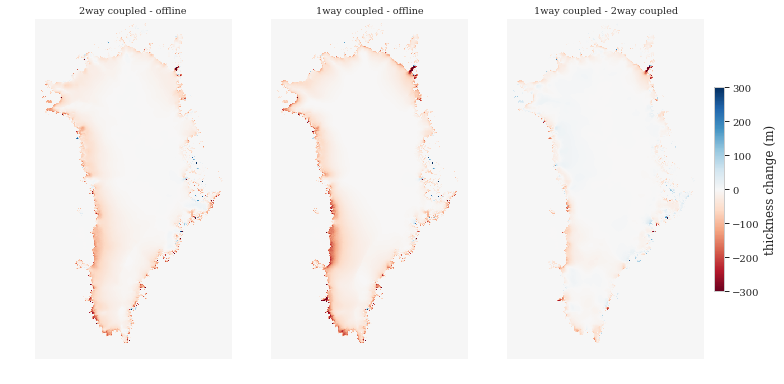

In [141]:

f, ax = plt.subplots(1,3,sharey = True, figsize = (12,8) )
v_max = 300
# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
diff = thk_cp -thk_e
m = thk_cp <0
diff[m]=np.nan
imi =ax[0].imshow(diff,origin = 'lower',cmap = "RdBu",vmin =-1*v_max,vmax=v_max)
ax[0].set_title('2way coupled - offline')

diff = thk_sef -thk_e
m = thk_sef <0
diff[m]=np.nan
imi =ax[1].imshow(diff,origin = 'lower',cmap = "RdBu",vmin =-1*v_max,vmax=v_max)
ax[1].set_title('1way coupled - offline')

diff = thk_sef -thk_cp
m = thk_sef <0
diff[m]=np.nan
imi =ax[2].imshow(diff,origin = 'lower',cmap = "RdBu",vmin =-1*v_max,vmax=v_max)
ax[2].set_title('1way coupled - 2way coupled')

axins1 = inset_axes(ax[2],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[2].transAxes,
                   borderpad=0,
                   )

for i in range (3):
    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = "thickness change (m)")

#### more ice loss in the -coupled experiment in general. Figure shows that both  coupling  lead to more ice loss than the offline experiment.  The  1-way coupling the ice looses more mass iwhile in the 2-way coupling experiment more ice is loss further inland along the (west ) coast and party on the east coast. 

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Text(0.5, 1.0, '2200 -1990')

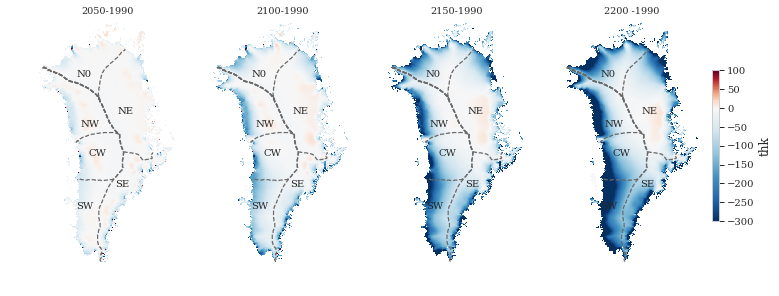

In [85]:
f, ax = plt.subplots(1,4,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
v_max=150
variable = 'thk'
v_0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', variable).values[0]


# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', variable)
v_coupling = d_thke_coupling.values[0] 
diff_2200 =v_coupling -v_0
m = v_coupling <=0
diff_2200[m]=np.nan

###############
# m0 =  da.read_nc(p_climato + 'gris_4500m-1990.nc', 'mask')
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', variable)
# d_thke_coupling2 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', 'thk').values[0]

v_coupling = d_thke_coupling.values[0] 
diff_2150 =v_coupling -v_0
m = v_coupling <=0

diff_2150[m]=np.nan

########
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2100.nc', variable)
v_coupling = d_thke_coupling.values[0] 
diff_2100 =v_coupling -v_0

m = v_coupling <=0

diff_2100[m]=np.nan

########
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2050.nc', variable)
v_coupling = d_thke_coupling.values[0] 
diff_2050 =v_coupling -v_0
m = v_coupling <=0

diff_2050[m]=np.nan
elev_min= -300
elev_max=100
mid_val=0


ax[0].imshow(diff_2050,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
# ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)

# imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)


# ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
# ax[2].imshow(m_sa_nan,origin = 'lower',norm =norm,cmap =cmap)
axins1 = inset_axes(ax[3],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[3].transAxes,
                   borderpad=0,
                   )

for i in range (4):
    ax[i].contour(basins, origin = 'lower',levels = [1,2,3,4,5,6], colors = 'dimgrey', linestyles= '--', linewidth = 1,)
    ax[i].text(100,470,'N0',fontsize = 10)
    ax[i].text(110,350,'NW',fontsize = 10)
    ax[i].text(200,380,'NE',fontsize = 10)
    ax[i].text(130,280,'CW',fontsize = 10)
    ax[i].text(100,150,'SW',fontsize = 10)
    ax[i].text(195,205,'SE',fontsize = 10)

    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = 'thk')

ax[0].set_title('2050-1990')
ax[1].set_title('2100-1990')
ax[2].set_title('2150-1990')
ax[3].set_title('2200 -1990')


# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)

# Velocity <a class="anchor" id="5-bullet"></a>

In [5]:
d_thk0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', 'velsurf_mag')
v_0 = d_thk0.values[0] 

# m0 =  da.read_nc(p_climato + 'gris_4500m-1990.nc', 'mask')
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'velsurf_mag')
v_coupling = d_thke_coupling.values[0] 
me_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'mask').values[0,]
mcp = me_coupling == (2 or 3)

d_thke_1way = da.read_nc(p_climato + 'marfix/'+'gris_4500m-2200.nc', 'velsurf_mag')
v_1way= d_thke_1way.values[0]


d_thke_standalone = da.read_nc(p_climato + 'pism-mar-fix/'+'gris_4500m-2200.nc', 'velsurf_mag')
v_standalone= d_thke_standalone.values[0]
# me_standalone = da.read_nc(p_climato + 'marfix/'+'gris_4500m-2200.nc', 'mask')

Text(0.5, 1.0, '2200 offline')

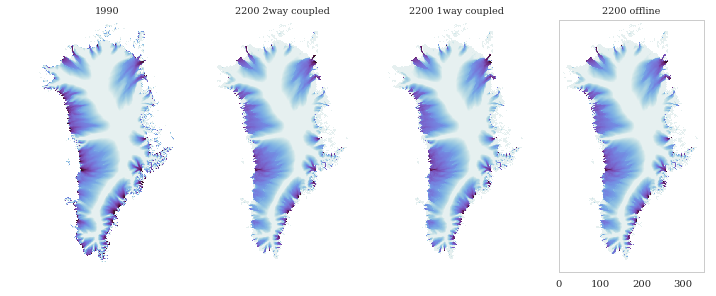

In [145]:
f, ax = plt.subplots(1,4,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
ax[0].imshow(v_0,origin = 'lower',cmap =cmocean.cm.dense,norm=LogNorm(vmin=10, vmax=1300))
ax[1].imshow(v_coupling,origin = 'lower',cmap =cmocean.cm.dense,norm=LogNorm(vmin=10, vmax=1300))
ax[2].imshow(v_1way,origin = 'lower',cmap =cmocean.cm.dense,norm=LogNorm(vmin=10, vmax=1300))

ax[3].imshow(v_standalone,origin = 'lower',cmap =cmocean.cm.dense,norm=LogNorm(vmin=10, vmax=1300))


# ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
# ax[2].imshow(m_sa_nan,origin = 'lower',norm =norm,cmap =cmap)

ax[0].set_axis_off()
ax[1].set_axis_off()

ax[2].set_axis_off()

ax[0].set_title('1990')
ax[1].set_title('2200 2way coupled')
ax[2].set_title('2200 1way coupled')
ax[3].set_title('2200 offline')


# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


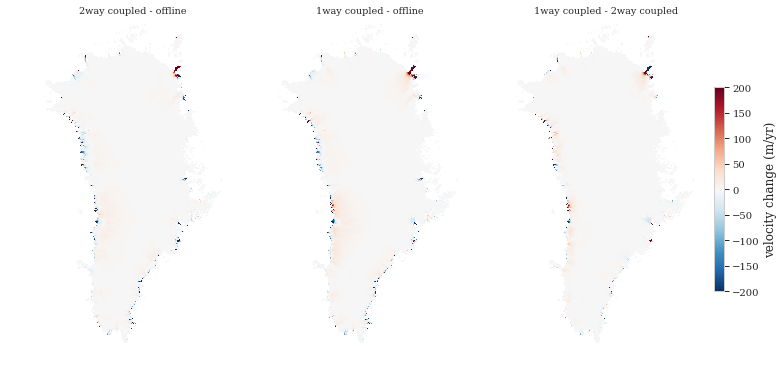

In [151]:

f, ax = plt.subplots(1,3,sharey = True, figsize = (12,8) )
v_max = 200
# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
diff =v_coupling -v_standalone
m = v_coupling <0
diff[m]=np.nan
imi =ax[0].imshow(diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
ax[0].set_title('2way coupled - offline')

diff = v_1way -v_standalone
m = v_1way <0
diff[m]=np.nan
imi =ax[1].imshow(diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
ax[1].set_title('1way coupled - offline')

diff = v_1way -v_coupling
m = v_1way <0
diff[m]=np.nan
imi =ax[2].imshow(diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
ax[2].set_title('1way coupled - 2way coupled')

axins1 = inset_axes(ax[2],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[2].transAxes,
                   borderpad=0,
                   )

for i in range (3):
    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = "velocity change (m/yr)")

In [163]:
path_to_rignot = '/home/beckmann/mnt/cluhome/icedata/pism_greenland_input/rignot_basins/'
d_basin = da.read_nc(path_to_rignot +'basins_rignot_4500m_nb.nc') 
list_basin = [
'NW_1',
    'CW_2',
'SW_3',
'SE_4',
    'NE_5',
'NO_6'
]
y,x=d_basin['basins'].shape
basins = np.zeros((y,x))
for i in range(len(list_basin)):
    b_i =d_basin[list_basin[i]].values
    m_i = b_i ==0
    basins[~m_i] = i+1
m = basins == 0
basins[m]=np.nan
basins.dump(path_to_rignot+ 'basins_thk' )


/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/dimarray/io/nc.py:624: RuntimeWarning: 'nv4' dimension not found, define integer range
  warnings.warn(msg, RuntimeWarning)


/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


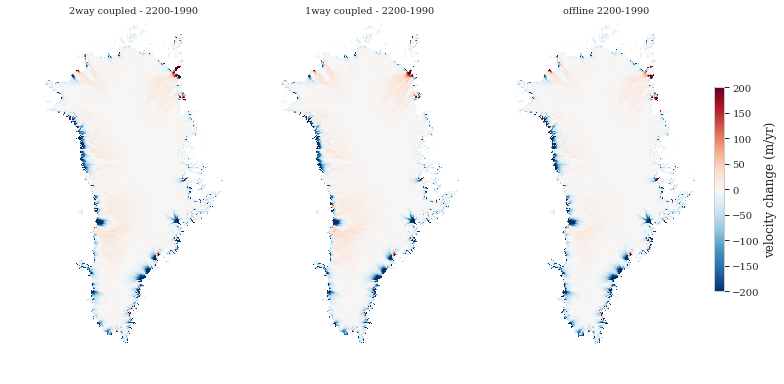

In [161]:

f, ax = plt.subplots(1,3,sharey = True, figsize = (12,8) )
v_max = 200
# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
diff =v_coupling -v_0
m = v_coupling <0
diff[m]=np.nan
imi =ax[0].imshow(diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
ax[0].set_title('2way coupled - 2200-1990')

diff = v_1way -v_0
m = v_1way <0
diff[~mcp]=np.nan
imi =ax[1].imshow(diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
ax[1].set_title('1way coupled - 2200-1990')

diff = v_standalone -v_0
m = v_1way <0
diff[m]=np.nan
imi =ax[2].imshow(diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
ax[2].set_title('offline 2200-1990')

axins1 = inset_axes(ax[2],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[2].transAxes,
                   borderpad=0,
                   )

for i in range (3):
    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = "velocity change (m/yr)")

In [24]:
path_to_rignot = '/home/beckmann/mnt/cluhome/icedata/pism_greenland_input/rignot_basins/'
# do = da.read_nc(bed_orig,'thickness')
# m = do.values <1
d_basin = da.read_nc(path_to_rignot +'basins_rignot_4500m_nb.nc') 
list_basin = [
'NW_1',
    'CW_2',
'SW_3',
'SE_4',
    'NE_5',
'NO_6'
]
y,x=d_basin['basins'].shape
basins = np.zeros((y,x))
for i in range(len(list_basin)):
    b_i =d_basin[list_basin[i]].values
    m_i = b_i ==0
    basins[~m_i] = i+1
m = basins == 0
basins[m]=np.nan
# basins.dump(path_to_rignot+ 'basins_thk' )

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/dimarray/io/nc.py:624: RuntimeWarning: 'nv4' dimension not found, define integer range
  warnings.warn(msg, RuntimeWarning)


/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in less
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'


Text(0.5, 1.0, '2200 -1990')

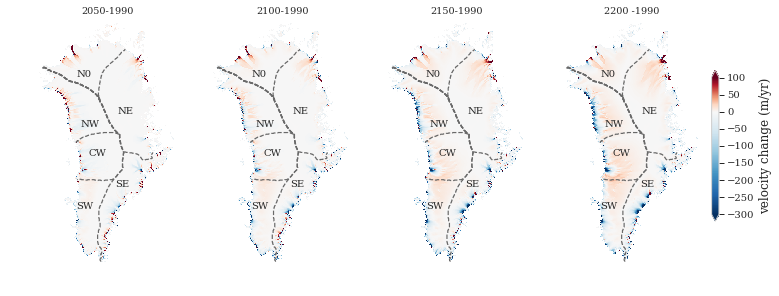

In [38]:
f, ax = plt.subplots(1,4,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
v_max=150

# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', 'velsurf_mag')
v_coupling = d_thke_coupling.values[0] 
diff_2200 =v_coupling -v_0
m = v_coupling <0
diff_2200[m]=np.nan

###############
# m0 =  da.read_nc(p_climato + 'gris_4500m-1990.nc', 'mask')
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', 'velsurf_mag')
d_thke_coupling2 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', 'thk').values[0]

v_coupling = d_thke_coupling.values[0] 
diff_2150 =v_coupling -v_0
m = d_thke_coupling2<=0
diff_2150[m]=np.nan

########
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2100.nc', 'velsurf_mag')
v_coupling = d_thke_coupling.values[0] 
diff_2100 =v_coupling -v_0
m = v_coupling <0
diff_2100[m]=np.nan

########
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2050.nc', 'velsurf_mag')
v_coupling = d_thke_coupling.values[0] 
diff_2050 =v_coupling -v_0
m = v_coupling <0
diff_2050[m]=np.nan
elev_min= -301
elev_max=101
mid_val=0


ax[0].imshow(diff_2050,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
# ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)

# imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)


# ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
# ax[2].imshow(m_sa_nan,origin = 'lower',norm =norm,cmap =cmap)
axins1 = inset_axes(ax[3],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[3].transAxes,
                   borderpad=0,
                   )

for i in range (4):
    ax[i].contour(basins, origin = 'lower',levels = [1,2,3,4,5,6], colors = 'dimgrey', linestyles= '--', linewidth = 1,)
    ax[i].text(100,470,'N0',fontsize = 10)
    ax[i].text(110,350,'NW',fontsize = 10)
    ax[i].text(200,380,'NE',fontsize = 10)
    ax[i].text(130,280,'CW',fontsize = 10)
    ax[i].text(100,150,'SW',fontsize = 10)
    ax[i].text(195,205,'SE',fontsize = 10)

    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = "velocity change (m/yr)",extend ='both')

ax[0].set_title('2050-1990')
ax[1].set_title('2100-1990')
ax[2].set_title('2150-1990')
ax[3].set_title('2200 -1990')


# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)

# Surfaces changes  <a class="anchor" id="6-bullet"></a>
Calculate SLR from SMB loss, attribute rest of SLR to dynamics.

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


Text(0.5, 1.0, '2200 -1990')

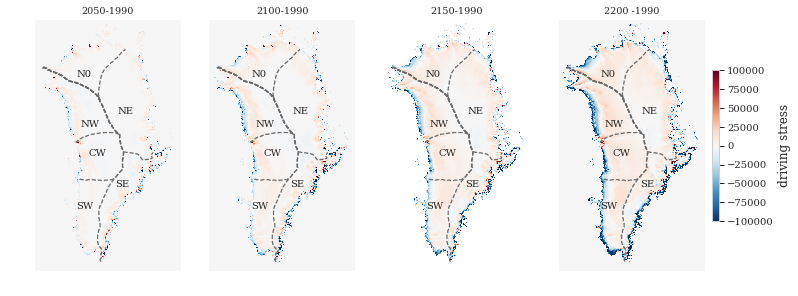

In [77]:
f, ax = plt.subplots(1,4,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
v_max=150
variable = 'taud_mag'
v_0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', variable).values[0]


# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', variable)
v_coupling = d_thke_coupling.values[0] 
diff_2200 =v_coupling -v_0
# m = v_coupling <0
# diff_2200[m]=np.nan

###############
# m0 =  da.read_nc(p_climato + 'gris_4500m-1990.nc', 'mask')
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', variable)
# d_thke_coupling2 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', 'thk').values[0]

v_coupling = d_thke_coupling.values[0] 
diff_2150 =v_coupling -v_0
m = d_thke_coupling2<=0
diff_2150[m]=np.nan

########
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2100.nc', variable)
v_coupling = d_thke_coupling.values[0] 
diff_2100 =v_coupling -v_0
m = v_coupling <0
diff_2100[m]=np.nan

########
d_thke_coupling = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2050.nc', variable)
v_coupling = d_thke_coupling.values[0] 
diff_2050 =v_coupling -v_0
m = v_coupling <0
diff_2050[m]=np.nan
elev_min= -100000
elev_max=100000
mid_val=0


ax[0].imshow(diff_2050,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
# ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)

# imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)


# ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
# ax[2].imshow(m_sa_nan,origin = 'lower',norm =norm,cmap =cmap)
axins1 = inset_axes(ax[3],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[3].transAxes,
                   borderpad=0,
                   )

for i in range (4):
    ax[i].contour(basins, origin = 'lower',levels = [1,2,3,4,5,6], colors = 'dimgrey', linestyles= '--', linewidth = 1,)
    ax[i].text(100,470,'N0',fontsize = 10)
    ax[i].text(110,350,'NW',fontsize = 10)
    ax[i].text(200,380,'NE',fontsize = 10)
    ax[i].text(130,280,'CW',fontsize = 10)
    ax[i].text(100,150,'SW',fontsize = 10)
    ax[i].text(195,205,'SE',fontsize = 10)

    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = 'driving stress')

ax[0].set_title('2050-1990')
ax[1].set_title('2100-1990')
ax[2].set_title('2150-1990')
ax[3].set_title('2200 -1990')


# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)

### driving stress -fucntion of thickness and surface slope-  increases in the interior and decreases at the margins 
$\tau_d = \rho_{ice}g H \frac{\delta h}{\delta s}$
As there is only thinning everywhere this is probably a steepening at the ice interior and maybe flattening at the margins?
Check with: 
$ \frac{\delta h}{\delta s}= \tau_d /\rho_{ice}g H$

/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in true_divide
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide
/home/beckmann/virtualenvironment/vpy3/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encoun

Text(0.5, 1.0, '2200 -1990')

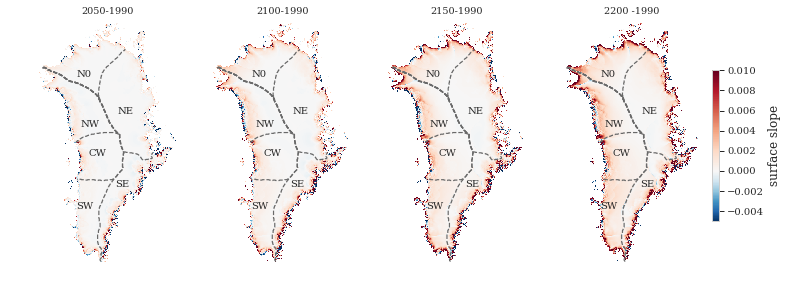

In [91]:
rho_ice = 910.0 
g = 9.81

f, ax = plt.subplots(1,4,sharey = True, figsize = (12,8) )
cmap = colors.ListedColormap(['skyblue'])
cmap_red = colors.ListedColormap(['red'])
bounds=[0,1]
norm = colors.BoundaryNorm(bounds, cmap.N)
v_max=150
variable = 'taud_mag'
variable2 = 'thk' 
tau_0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', variable).values[0]
thk_0 = da.read_nc(p_climato + 'gris_4500m-1990.nc', variable2).values[0]
m = thk_0 >0
v_0 = tau_0/(rho_ice*g*thk_0)
v_0[~m]=np.nan


# imi =ax.imshow(thk_diff,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
tau_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', variable).values[0]
thk_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2200.nc', variable2).values[0]

diff_2200 =tau_1/(rho_ice*g*thk_1) -v_0
m = thk_1 <=0
diff_2200[m]=np.nan

###############
tau_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', variable).values[0]
thk_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2150.nc', variable2).values[0]

diff_2150 =tau_1/(rho_ice*g*thk_1) -v_0
m = thk_1 <=0
diff_2150[m]=np.nan
########
tau_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2100.nc', variable).values[0]
thk_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2100.nc', variable2).values[0]

diff_2100 =tau_1/(rho_ice*g*thk_1) -v_0
m = thk_1 <=0
diff_2100[m]=np.nan
########
tau_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2050.nc', variable).values[0]
thk_1 = da.read_nc(p_climato +'coupling-1yr/'+ 'gris_4500m-2050.nc', variable2).values[0]

diff_2050 =tau_1/(rho_ice*g*thk_1) -v_0
m = thk_1 <=0
diff_2050[m]=np.nan
####
elev_min= -0.005
elev_max=0.01

mid_val=0


ax[0].imshow(diff_2050,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))
imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",clim=(elev_min, elev_max), norm=MidpointNormalize(midpoint=mid_val,vmin=elev_min, vmax=elev_max))

# ax[1].imshow(diff_2100,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)
# ax[2].imshow(diff_2150,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)

# imi=ax[3].imshow(diff_2200,origin = 'lower',cmap = "RdBu_r",vmin =-1*v_max,vmax=v_max)


# ax[1].imshow(m_cp_nan,origin = 'lower',norm =norm,cmap =cmap)
# ax[2].imshow(m_sa_nan,origin = 'lower',norm =norm,cmap =cmap)
axins1 = inset_axes(ax[3],
                   width="5%",  # width = 5% of parent_bbox width
                   height="60%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.05, 0.2, 1, 1),
                   bbox_transform=ax[3].transAxes,
                   borderpad=0,
                   )

for i in range (4):
    ax[i].contour(basins, origin = 'lower',levels = [1,2,3,4,5,6], colors = 'dimgrey', linestyles= '--', linewidth = 1,)
    ax[i].text(100,470,'N0',fontsize = 10)
    ax[i].text(110,350,'NW',fontsize = 10)
    ax[i].text(200,380,'NE',fontsize = 10)
    ax[i].text(130,280,'CW',fontsize = 10)
    ax[i].text(100,150,'SW',fontsize = 10)
    ax[i].text(195,205,'SE',fontsize = 10)

    ax[i].set_axis_off()
cbar1 =f.colorbar(imi, cax=axins1,label = "surface slope")

ax[0].set_title('2050-1990')
ax[1].set_title('2100-1990')
ax[2].set_title('2150-1990')
ax[3].set_title('2200 -1990')


# f.savefig(path_plot+'mask1970.png', transparent=True,dpi = 150)